In [68]:
import boto3
import pandas as pd
import numpy as np
import configparser
import psycopg2
import hashlib
import uuid
from faker import Faker
import random
import matplotlib.pyplot as plt

# Config setup

In [43]:
etl_config = configparser.ConfigParser()
etl_config.read('etl_config.cfg')

['etl_config.cfg']

In [44]:
tran_config = configparser.ConfigParser()
tran_config.read('transactional_config.cfg')

['transactional_config.cfg']

# AWS client connection

In [45]:
access_key = etl_config.get('IAM', 'ACCESS_KEY')
secret_key = etl_config.get('IAM', 'SECRET_KEY')
region = etl_config.get('REGION', 'REGION_NAME')

aws_rds_conn = boto3.client('rds', 
                            aws_access_key_id=access_key, 
                            aws_secret_access_key=secret_key, 
                            region_name=region)

# AWS RDS creation

In [46]:
etl_db_instance_id = etl_config.get('DB', 'DB_INSTANCE_ID')
etl_db_name = etl_config.get('DB', 'DB_NAME')
etl_db_username = etl_config.get('DB', 'DB_USERNAME')
etl_db_password = etl_config.get('DB', 'DB_PASSWORD')
etl_db_port = etl_config.get('DB', 'DB_PORT')
etl_vpc_security_group = etl_config.get('VPC', 'SECURITY_GROUP')

In [47]:
tran_db_instance_id = tran_config.get('DB', 'DB_INSTANCE_ID')
tran_db_name = tran_config.get('DB', 'DB_NAME')
tran_db_username = tran_config.get('DB', 'DB_USERNAME')
tran_db_password = tran_config.get('DB', 'DB_PASSWORD')
tran_db_port = tran_config.get('DB', 'DB_PORT')
tran_vpc_security_group = tran_config.get('VPC', 'SECURITY_GROUP')

In [48]:
try:
    response = aws_rds_conn.create_db_instance(
        DBInstanceIdentifier=etl_db_instance_id,
        DBName=etl_db_name,
        MasterUsername=etl_db_username,
        MasterUserPassword=etl_db_password,
        Port=int(etl_db_port),
        DBInstanceClass='db.t3.micro',
        Engine='mysql',
        PubliclyAccessible=True,
        AllocatedStorage=20,
        VpcSecurityGroupIds=[etl_vpc_security_group]
    )
    print(response)
except aws_rds_conn.exceptions.DBInstanceAlreadyExistsFault:
    print('La instancia ya existe')
except Exception as ex:
    print(f"Error: ${ex}")

La instancia ya existe


# RDS host name

In [49]:
try:
    etl_instance = aws_rds_conn.describe_db_instances(DBInstanceIdentifier=etl_db_instance_id)
    ETL_RDS_HOST_NAME = etl_instance.get('DBInstances')[0].get('Endpoint').get('Address')
    print(ETL_RDS_HOST_NAME)
except Exception as ex:
    print('Error: ', ex)

dwshop.cnkf6pwg5si3.us-east-2.rds.amazonaws.com


In [ ]:
etl_driver = f"""mysql://{etl_db_username}:{etl_db_password}@{ETL_RDS_HOST_NAME}:{etl_db_port}/{etl_db_name}"""
etl_driver

In [51]:
try:
    tran_instance = aws_rds_conn.describe_db_instances(DBInstanceIdentifier=tran_db_instance_id)
    TRAN_RDS_HOST_NAME = tran_instance.get('DBInstances')[0].get('Endpoint').get('Address')
    print(TRAN_RDS_HOST_NAME)
except Exception as ex:
    print('Error: ', ex)

shop.cnkf6pwg5si3.us-east-2.rds.amazonaws.com


In [ ]:
tran_driver = f"""postgresql://{tran_db_username}:{tran_db_password}@{TRAN_RDS_HOST_NAME}:{tran_db_port}/{tran_db_name}"""
tran_driver

# Creation of ETL system

## Dimension Categoría (dimCategoria)

In [65]:
# Tuve que instalar esto
#!pip install mysqlclient

In [70]:
sql_query = 'SELECT * FROM categoria;'
df_categorias = pd.read_sql(sql_query, tran_driver)
df_categorias.head()

#No hice merge porque solo usamos esta tabla
# dimCategorias = df_clientes_direcciones_gen.merge(df_sectores, how='inner', on='id_sector', suffixes=('', '_sucursal'))
dimCategorias = df_categorias.drop(['estado'], axis=1,  inplace=False)
#dimCategorias['categoria_id'] = range(1, len(df_categorias)+1)
#dimCategorias.set_index('categoria_id', inplace=True)
dimCategorias


,idcategoria,nombre,descripcion
0,1,Electrónica,Dispositivos y gadgets tecnológicos de última ...
1,2,Ropa Hombres,Moda y accesorios para el vestuario masculino.
2,3,Ropa Mujeres,Colecciones y tendencias de moda femenina.
3,4,Juguetes,Juguetes educativos y de entretenimiento para ...
4,5,Alimentos,Productos alimenticios frescos y procesados pa...
5,6,Bebidas,"Variedad de bebidas refrescantes, alcohólicas ..."
6,7,Libros,"Literatura, ficción, educativos y más géneros ..."
7,8,Artículos de Oficina,Suministros y mobiliario para mejorar tu espac...
8,9,Deportes,Equipamiento y ropa deportiva para todas tus a...
9,10,Zapatos,"Calzado cómodo y estilizado para hombres, muje..."


In [54]:
dimCategorias.to_sql('dimCategoria', etl_driver, index=False, if_exists='append')


25

## Dimension Producto (dimProducto)

In [55]:
sql_query = 'SELECT * FROM articulo;'
df_articulo = pd.read_sql(sql_query, tran_driver)
df_articulo.head()

df_articulo=df_articulo.rename(columns={ 'idarticulo':'idproducto','nombre':'nombre_producto', 'descripcion':'descripcion_producto', 'estado':'estado_producto'})

dimProducto = df_articulo.merge( df_categorias ,on='idcategoria', how='inner')
dimProducto

dimProducto = dimProducto.drop(['imagen','descripcion', 'estado','precio_venta','stock','estado_producto','nombre'], axis=1,  inplace=False)

dimProducto=dimProducto.rename(columns={'nombre_producto':'nombre', 'descripcion_producto':'descripcion'})

dimProducto


,idproducto,idcategoria,codigo,nombre,descripcion
0,1,16,Lpe-066,maintain,Skill north shake very environment.
1,5,16,awM-369,method,Expect deep develop number shake.
2,26,16,eLE-025,control,Tv raise everyone measure point.
3,42,16,Hsv-468,region,Election include meeting visit kind baby future.
4,81,16,ZvH-481,weight,Sound man along teacher section Mrs effort.
...,...,...,...,...,...
995,909,24,MKa-517,man,Must meeting none right trial reduce body.
996,930,24,doX-032,term,Own play remain pattern seem office.
997,932,24,Aag-804,throughout,Early son society available full job wife.
998,982,24,zNu-727,onto,New into reach audience course child doctor.


In [56]:
dimProducto.to_sql('dimProducto', etl_driver, index=False, if_exists='append')

1000

## Dimension Empleado (dimEmpleado)

In [57]:
sql_query = 'SELECT * FROM usuario;'
df_usuario= pd.read_sql(sql_query, tran_driver)
df_usuario.head()

,idusuario,idrol,nombre,tipo_documento,num_documento,direccion,telefono,email,clave,estado
0,2001,1,Benjamin Freeman,DNI,59284701,57970 Rebecca Overpass Apt. 548\nPort Christop...,558.288.5315x231,kevin86@example.net,"[b'1', b'\x0b', b'\x81', b'\x08', b'\x04', b'\...",False
1,2002,7,Teresa Scott,CE,60853179,"2138 Jennifer Route Apt. 078\nShaneburgh, MI 6...",+1-691-814-0767x3135,stephen91@example.com,"[b'\x9b', b'(', b'\xdb', b's', b'\xc1', b'\x06...",True
2,2003,6,Kristy Bryant,PAS,43600713,"3881 Rivera Island Apt. 547\nJacksonborough, A...",+1-593-748-3539,mphillips@example.org,"[b'I', b'8', b'\t', b'D', b'i', b'%', b'\xb6',...",True
3,2004,4,Stephanie Valdez,CE,87343034,"54802 Floyd Glen\nFinleyfort, SD 23493",001-859-353-8620x628,john41@example.org,"[b'D', b'\xab', b'\xc6', b'>', b'z', b'O', b'&...",False
4,2005,6,Jason Oliver,CE,68984842,"9618 West Orchard\nNew Adamfurt, MP 71415",548.204.6338,pamela28@example.com,"[b'~', b'\x0e', b'\x94', b'b', b'b', b'\x05', ...",True


In [58]:
sql_query = 'SELECT * FROM rol;'
df_rol= pd.read_sql(sql_query, tran_driver)
df_rol = df_rol.rename(columns={'nombre':'nombre_rol', 'estado':'estado_rol'})
df_rol.head()

,idrol,nombre_rol,descripcion,estado_rol
0,1,Administrador,"Responsable de gestionar la tienda, incluidos ...",True
1,2,Vendedor,Encargado de las ventas y la atención al clien...,True
2,3,Cajero,Gestiona las transacciones de pago y emite rec...,True
3,4,Gerente de Producto,"Supervisa la selección, precios y promoción de...",True
4,5,Soporte Técnico,Proporciona asistencia técnica para productos ...,True


In [59]:
dimEmpleado = pd.merge(df_usuario, df_rol, on='idrol', how='inner' )
dimEmpleado

,idusuario,idrol,nombre,tipo_documento,num_documento,direccion,telefono,email,clave,estado,nombre_rol,descripcion,estado_rol
0,2001,1,Benjamin Freeman,DNI,59284701,57970 Rebecca Overpass Apt. 548\nPort Christop...,558.288.5315x231,kevin86@example.net,"[b'1', b'\x0b', b'\x81', b'\x08', b'\x04', b'\...",False,Administrador,"Responsable de gestionar la tienda, incluidos ...",True
1,2023,1,Michelle Reed,CE,01993958,"4968 Amber Manors Suite 471\nEdwardbury, CA 58761",(462)655-7336x48393,tiffany60@example.com,"[b'\x9e', b'\xbd', b'\xf1', b'\xba', b'R', b'K...",False,Administrador,"Responsable de gestionar la tienda, incluidos ...",True
2,2024,1,Ernest Matthews,DNI,89437391,"444 Jaime Turnpike Suite 925\nSusanshire, IN 1...",+1-252-540-0767x654,lori78@example.com,"[b'\xbb', b'\xa8', b'1', b'\xdb', b'\xf9', b'\...",True,Administrador,"Responsable de gestionar la tienda, incluidos ...",True
3,2027,1,Katherine Noble,PAS,47984726,"1686 Kevin Haven\nPort Daniel, NY 81804",(602)772-3743x3708,sdavis@example.com,"[b'\xa2', b'\x98', b'\xd6', b'1', b'E', b't', ...",True,Administrador,"Responsable de gestionar la tienda, incluidos ...",True
4,2032,1,Mr. Gregory Watts,CE,83377606,"065 Smith Cliff Suite 347\nSouth Tracy, MA 29335",+1-686-206-0996x0341,vanessascott@example.org,"[b'\xf4', b'\x8b', b'\xe2', b'\xc0', b'#', b'\...",True,Administrador,"Responsable de gestionar la tienda, incluidos ...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2932,5,Mason Davis,CE,32313465,"621 Randall Heights Apt. 577\nEast Jessica, SD...",(784)542-9846x1210,ihardin@example.org,"[b'\x8f', b'!', b'S', b'/', b'w', b'\x8a', b'\...",True,Soporte Técnico,Proporciona asistencia técnica para productos ...,True
996,2964,5,Jeffrey Carey,CE,50700203,Unit 0108 Box 7351\nDPO AE 81954,001-433-218-9033x630,angelaturner@example.com,"[b'\xe8', b'\xed', b'\xdf', b'\xd1', b'K', b'\...",False,Soporte Técnico,Proporciona asistencia técnica para productos ...,True
997,2989,5,Albert Pugh,DNI,45689369,"04528 Rodriguez Spurs\nJohnsonburgh, WV 08652",958.971.2087,tmorales@example.com,"[b'W', b'\xe7', b'.', b'\x19', b'\xb9', b'Y', ...",True,Soporte Técnico,Proporciona asistencia técnica para productos ...,True
998,2994,5,Jason Luna,DNI,24609849,"PSC 8222, Box 6327\nAPO AE 19396",+1-421-676-5047x5678,briancarr@example.net,"[b';', b'}', b'\x13', b'I', b'\xe3', b'\xa8', ...",True,Soporte Técnico,Proporciona asistencia técnica para productos ...,True


In [60]:
dimEmpleado = dimEmpleado.drop(['estado', 'estado_rol','idrol', 'clave','descripcion'], axis = 1, inplace= False)
dimEmpleado = dimEmpleado.rename(columns={'idusuario':'idempleado','nombre_rol': 'rol'})
dimEmpleado



,idempleado,nombre,tipo_documento,num_documento,direccion,telefono,email,rol
0,2001,Benjamin Freeman,DNI,59284701,57970 Rebecca Overpass Apt. 548\nPort Christop...,558.288.5315x231,kevin86@example.net,Administrador
1,2023,Michelle Reed,CE,01993958,"4968 Amber Manors Suite 471\nEdwardbury, CA 58761",(462)655-7336x48393,tiffany60@example.com,Administrador
2,2024,Ernest Matthews,DNI,89437391,"444 Jaime Turnpike Suite 925\nSusanshire, IN 1...",+1-252-540-0767x654,lori78@example.com,Administrador
3,2027,Katherine Noble,PAS,47984726,"1686 Kevin Haven\nPort Daniel, NY 81804",(602)772-3743x3708,sdavis@example.com,Administrador
4,2032,Mr. Gregory Watts,CE,83377606,"065 Smith Cliff Suite 347\nSouth Tracy, MA 29335",+1-686-206-0996x0341,vanessascott@example.org,Administrador
...,...,...,...,...,...,...,...,...
995,2932,Mason Davis,CE,32313465,"621 Randall Heights Apt. 577\nEast Jessica, SD...",(784)542-9846x1210,ihardin@example.org,Soporte Técnico
996,2964,Jeffrey Carey,CE,50700203,Unit 0108 Box 7351\nDPO AE 81954,001-433-218-9033x630,angelaturner@example.com,Soporte Técnico
997,2989,Albert Pugh,DNI,45689369,"04528 Rodriguez Spurs\nJohnsonburgh, WV 08652",958.971.2087,tmorales@example.com,Soporte Técnico
998,2994,Jason Luna,DNI,24609849,"PSC 8222, Box 6327\nAPO AE 19396",+1-421-676-5047x5678,briancarr@example.net,Soporte Técnico


In [61]:
dimEmpleado.to_sql('dimEmpleado', etl_driver, index=False, if_exists='append')

1000

## Dimension Comprobante (dimComprobante)

In [62]:
sql_query = 'SELECT DISTINCT(tipo_comprobante) FROM venta;'
df_comprobante= pd.read_sql(sql_query, tran_driver)
df_comprobante.head()
df_comprobante['idcomprobante'] = range(2)
df_comprobante['idcomprobante'] = df_comprobante['idcomprobante'] +1
dimComprobante = df_comprobante
dimComprobante

,tipo_comprobante,idcomprobante
0,Factura,1
1,Boleta,2


In [63]:
dimComprobante.to_sql('dimComprobante', etl_driver, index=False, if_exists='append')

2

## FACT TABLE 

In [64]:
sql_query = 'SELECT idventa, idusuario AS idempleado, total AS total_venta, fecha, tipo_comprobante FROM venta;'
df_venta= pd.read_sql(sql_query, tran_driver)
df_venta.head()

,idventa,idempleado,total_venta,fecha,tipo_comprobante
0,1,2813,72.86,2024-01-14 04:12:48.458677,Boleta
1,2,2220,763.62,2024-01-02 11:12:29.773908,Factura
2,3,2227,617.78,2024-02-13 20:40:40.808368,Boleta
3,4,2815,250.48,2024-02-27 06:24:16.011434,Factura
4,5,2075,567.00,2024-01-16 13:29:55.412727,Factura


In [65]:
sql_query = 'SELECT idventa, idarticulo AS idproducto, cantidad, precio AS precio_venta, descuento AS descuento_venta FROM detalle_venta;'
df_detalleVenta= pd.read_sql(sql_query, tran_driver)
df_detalleVenta.head()

,idventa,idproducto,cantidad,precio_venta,descuento_venta
0,1,899,5,46.22,7.46
1,1,732,6,38.60,4.50
2,2,913,6,10.62,3.49
3,2,879,6,30.12,8.42
4,2,461,1,46.26,5.33


In [66]:
factVentas = pd.merge(df_venta, df_detalleVenta, on='idventa', how='inner' )
factVentas = factVentas.merge(dimComprobante, on = 'tipo_comprobante', how='inner')
factVentas = factVentas.drop(['tipo_comprobante'], axis=1, inplace= False)
factVentas

,idventa,idempleado,total_venta,fecha,idproducto,cantidad,precio_venta,descuento_venta,idcomprobante
0,1,2813,72.86,2024-01-14 04:12:48.458677,899,5,46.22,7.46,2
1,1,2813,72.86,2024-01-14 04:12:48.458677,732,6,38.60,4.50,2
2,3,2227,617.78,2024-02-13 20:40:40.808368,60,5,78.26,1.41,2
3,3,2227,617.78,2024-02-13 20:40:40.808368,477,4,19.10,1.26,2
4,3,2227,617.78,2024-02-13 20:40:40.808368,322,5,44.04,9.81,2
...,...,...,...,...,...,...,...,...,...
39954,5000,2310,229.02,2024-03-26 08:04:17.577006,320,3,20.14,5.94,1
39955,5000,2310,229.02,2024-03-26 08:04:17.577006,365,5,73.81,4.08,1
39956,5000,2310,229.02,2024-03-26 08:04:17.577006,83,7,29.82,1.85,1
39957,5000,2310,229.02,2024-03-26 08:04:17.577006,249,9,24.80,1.58,1


In [67]:
factVentas.to_sql('factVentas', etl_driver, index=False, if_exists='append')

39959

# Preguntas

## 1. ¿Cuál es el total de ventas por categoría de producto?

====> Respuesta: Electrónica es la categoría con el mayor total de ventas, con un total de ventas de 1249364.52


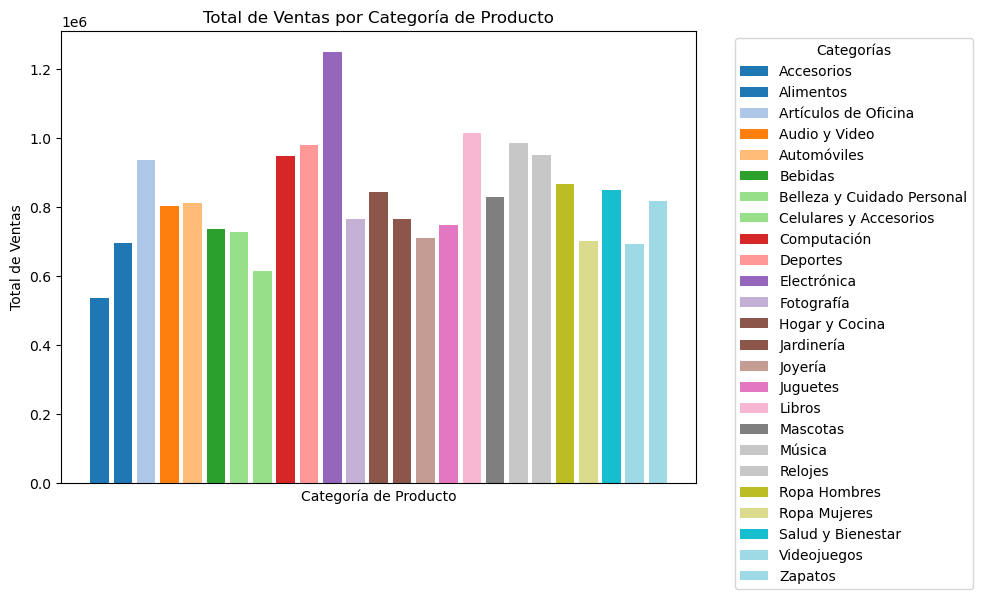

In [83]:
# Obteniendo producto y categoria
ventas_categoria = pd.merge(factVentas, dimProducto, on='idproducto')
ventas_categoria = pd.merge(ventas_categoria, dimCategorias, on='idcategoria')
ventas_categoria = ventas_categoria.rename(columns={'nombre_x':'nombre_producto','nombre_y': 'nombre_categoria'})
ventas_categoria = ventas_categoria.rename(columns={'descripcion_x':'descripcion_producto','descripcion_y': 'descripcion_categoria'})

# Calculando el total de venta por categoria
total_ventas_categoria = ventas_categoria.groupby('nombre_categoria')['total_venta'].sum().reset_index()

categoria_max_venta = total_ventas_categoria.loc[total_ventas_categoria['total_venta'].idxmax()]
print(f"====> Respuesta: {categoria_max_venta['nombre_categoria']} es la categoría con el mayor total de ventas, con un total de ventas de {categoria_max_venta['total_venta']}")

# Asignando un color único a cada categoría usando una paleta más diversa
colors = plt.cm.tab20(np.linspace(0, 1, len(total_ventas_categoria)))

# Graficando
plt.figure(figsize=(10, 6))
bars = plt.bar(total_ventas_categoria['nombre_categoria'], total_ventas_categoria['total_venta'], color=colors)

plt.xlabel('Categoría de Producto')
plt.ylabel('Total de Ventas')
plt.title('Total de Ventas por Categoría de Producto')
plt.xticks([])  # Elimina las etiquetas del eje x

# Moviendo las categorías al lado derecho
plt.legend(bars, total_ventas_categoria['nombre_categoria'], title="Categorías", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Ajusta la disposición para no cortar la leyenda
plt.show()



## 2. ¿Cuál es el rendimiento de ventas de cada empleado?

====> Respuesta: Michael Brock es el empleado con el mayor total de ventas, alcanzando un total de ventas de 110210.66.


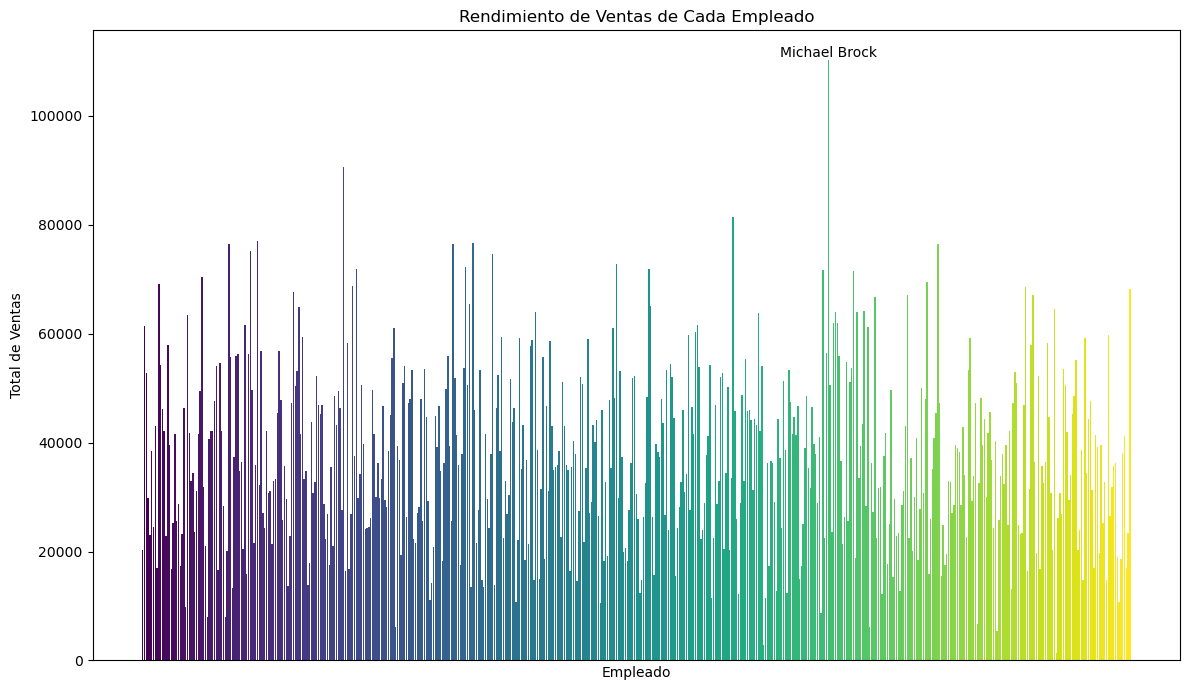

In [101]:
# Obteniendo datos de empleados y ventas
ventas_empleado = pd.merge(factVentas, dimEmpleado, on='idempleado')
ventas_empleado = ventas_empleado.rename(columns={'nombre': 'nombre_empleado'})

# Calculando el total de ventas por empleado
total_ventas_empleado = ventas_empleado.groupby('nombre_empleado')['total_venta'].sum().reset_index()

# Identificando el empleado con máximas ventas
empleado_max_venta = total_ventas_empleado.loc[total_ventas_empleado['total_venta'].idxmax()]
print(f"====> Respuesta: {empleado_max_venta['nombre_empleado']} es el empleado con el mayor total de ventas, alcanzando un total de ventas de {empleado_max_venta['total_venta']}.")

# Asignando un color único a cada empleado usando una paleta diversa
colors = plt.cm.viridis(np.linspace(0, 1, len(total_ventas_empleado)))

# Graficando
plt.figure(figsize=(12, 7))
bars = plt.bar(total_ventas_empleado['nombre_empleado'], total_ventas_empleado['total_venta'], color=colors)

plt.xlabel('Empleado')
plt.ylabel('Total de Ventas')
plt.title('Rendimiento de Ventas de Cada Empleado')
plt.xticks([])

# Agregando el nombre del empleado con las máximas ventas sobre la barra correspondiente
for bar, name, value in zip(bars, total_ventas_empleado['nombre_empleado'], total_ventas_empleado['total_venta']):
    if name == empleado_max_venta['nombre_empleado']:
        plt.text(bar.get_x() + bar.get_width()/2, value, name, va='bottom', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()



## 3. Efectividad de Cada Tipo de Comprobante en Términos de Ventas

====> Respuesta: El tipo de comprobante 'Boleta' genera el mayor total de ventas, alcanzando un total de ventas de 10385689.06.


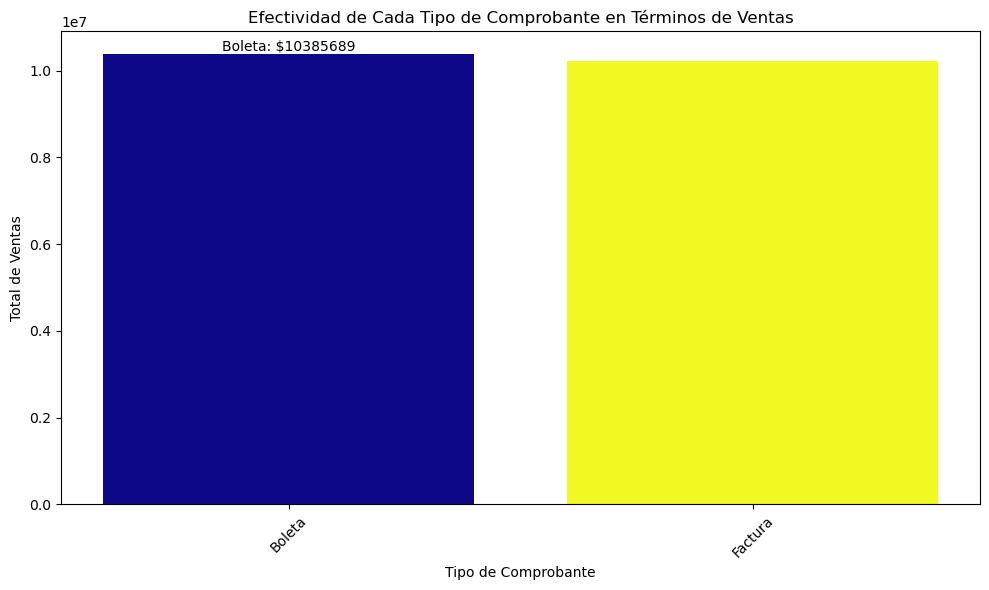

In [103]:
# Obteniendo datos de comprobantes y ventas
ventas_comprobante = pd.merge(factVentas, dimComprobante, on='idcomprobante')

# Calculando el total de ventas por tipo de comprobante
total_ventas_comprobante = ventas_comprobante.groupby('tipo_comprobante')['total_venta'].sum().reset_index()

# Identificando el tipo de comprobante con máximas ventas
comprobante_max_venta = total_ventas_comprobante.loc[total_ventas_comprobante['total_venta'].idxmax()]
print(f"====> Respuesta: El tipo de comprobante '{comprobante_max_venta['tipo_comprobante']}' genera el mayor total de ventas, alcanzando un total de ventas de {comprobante_max_venta['total_venta']}.")

# Asignando un color único a cada tipo de comprobante usando una paleta diversa
colors = plt.cm.plasma(np.linspace(0, 1, len(total_ventas_comprobante)))

# Graficando
plt.figure(figsize=(10, 6))
bars = plt.bar(total_ventas_comprobante['tipo_comprobante'], total_ventas_comprobante['total_venta'], color=colors)

plt.xlabel('Tipo de Comprobante')
plt.ylabel('Total de Ventas')
plt.title('Efectividad de Cada Tipo de Comprobante en Términos de Ventas')
plt.xticks(rotation=45)  # Mejorar la legibilidad de las etiquetas

# Agregando el nombre del tipo de comprobante con las máximas ventas sobre la barra correspondiente
for bar, label in zip(bars, total_ventas_comprobante['tipo_comprobante']):
    yval = bar.get_height()
    if label == comprobante_max_venta['tipo_comprobante']:
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{label}: ${int(yval)}", va='bottom', ha='center', color='black', fontsize=10)

plt.tight_layout()  # Ajusta la disposición para no cortar el texto
plt.show()



## 4. ¿Cuál es la tendencia mensual de ventas en el último año?


====> Respuesta: El mes con mayor ventas es 2024-03 con un total de ventas de 6441452.64.


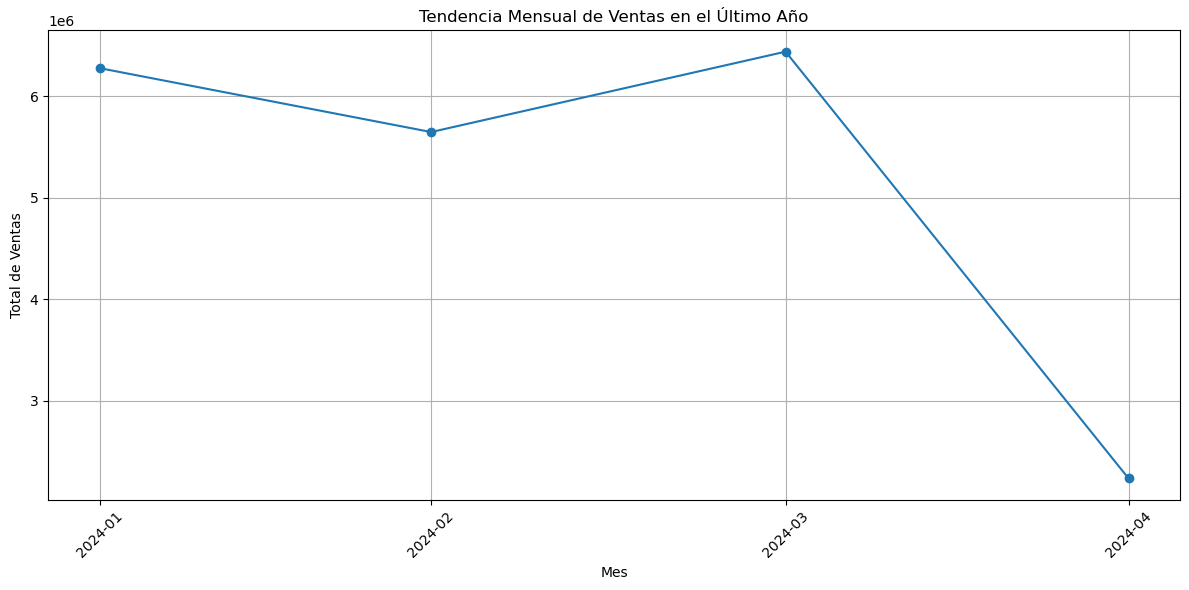

In [105]:
# Conversión de la columna 'fecha' a datetime
factVentas['fecha'] = pd.to_datetime(factVentas['fecha'])

# Filtrando ventas del último año
end_date = factVentas['fecha'].max()
start_date = end_date - pd.DateOffset(years=1)
ventas_ultimo_año = factVentas[(factVentas['fecha'] >= start_date) & (factVentas['fecha'] <= end_date)]

# Agrupando por mes y sumando las ventas
ventas_mensuales = ventas_ultimo_año.groupby(pd.Grouper(key='fecha', freq='M'))['total_venta'].sum().reset_index()

# Resultado clave
max_venta_mes = ventas_mensuales.loc[ventas_mensuales['total_venta'].idxmax()]
print(f"====> Respuesta: El mes con mayor ventas es {max_venta_mes['fecha'].strftime('%Y-%m')} con un total de ventas de {max_venta_mes['total_venta']}.")

# Graficando la tendencia mensual de ventas
plt.figure(figsize=(12, 6))
plt.plot(ventas_mensuales['fecha'], ventas_mensuales['total_venta'], marker='o', linestyle='-')
plt.title('Tendencia Mensual de Ventas en el Último Año')
plt.xlabel('Mes')
plt.ylabel('Total de Ventas')
plt.grid(True)
plt.xticks(ventas_mensuales['fecha'], [date.strftime('%Y-%m') for date in ventas_mensuales['fecha']], rotation=45)
plt.tight_layout()
plt.show()


## 5. ¿Cómo se distribuye el descuento promedio por categoría de producto y su impacto en las ventas?

====> Respuesta: La categoría 'Electrónica' tiene el mayor volumen de ventas de $1249364.52 con un descuento promedio de $1.40.


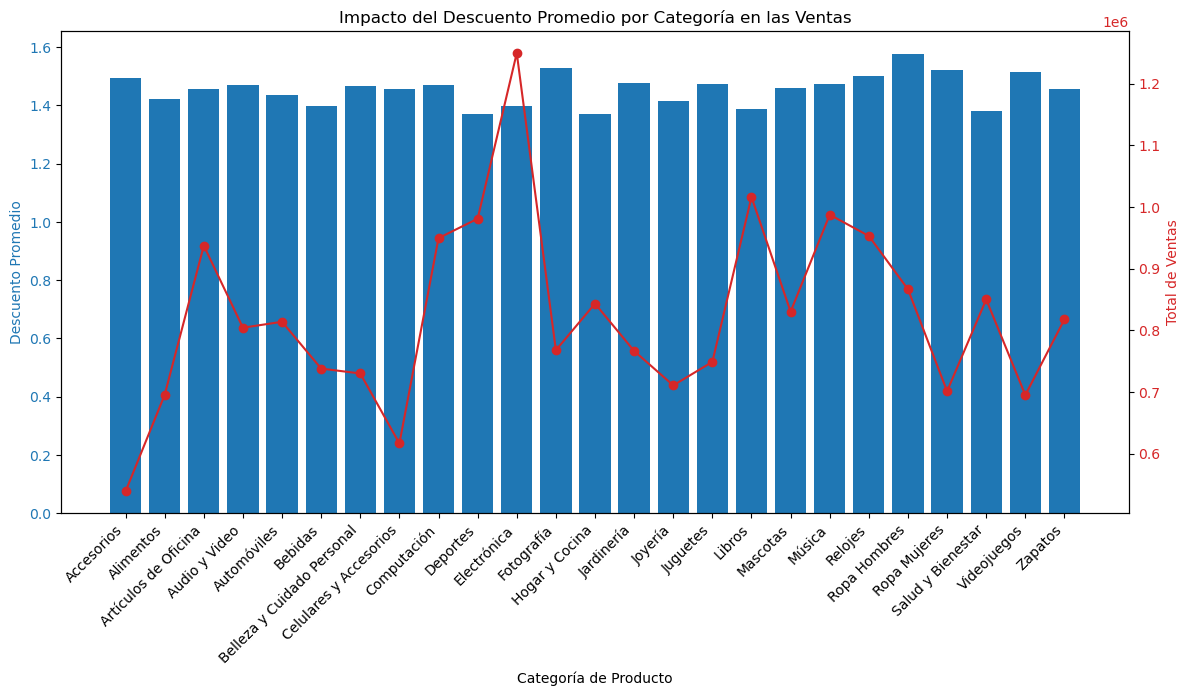

In [110]:
# Obteniendo descuentos y categorías
descuentos_categoria = pd.merge(factVentas, dimProducto, on='idproducto')
descuentos_categoria = pd.merge(descuentos_categoria, dimCategorias, on='idcategoria')
descuentos_categoria['descuento_promedio'] = descuentos_categoria['descuento_venta'] / descuentos_categoria['cantidad']
descuentos_categoria = descuentos_categoria.rename(columns={'nombre_x':'nombre_producto','nombre_y': 'nombre_categoria'})

# Calculando el descuento promedio y total de ventas por categoría
resumen_descuentos = descuentos_categoria.groupby('nombre_categoria').agg(
    descuento_promedio=('descuento_promedio', 'mean'),
    total_ventas=('total_venta', 'sum')
).reset_index()

# Resultado clave
categoria_mayor_impacto = resumen_descuentos.loc[resumen_descuentos['total_ventas'].idxmax()]
print(f"====> Respuesta: La categoría '{categoria_mayor_impacto['nombre_categoria']}' tiene el mayor volumen de ventas de ${categoria_mayor_impacto['total_ventas']:.2f} con un descuento promedio de ${categoria_mayor_impacto['descuento_promedio']:.2f}.")

# Graficando
fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('Categoría de Producto')
ax1.set_ylabel('Descuento Promedio', color=color)
bars = ax1.bar(resumen_descuentos['nombre_categoria'], resumen_descuentos['descuento_promedio'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Especificar FixedLocator para los ticks x
ax1.set_xticks(range(len(resumen_descuentos['nombre_categoria'])))
ax1.set_xticklabels(resumen_descuentos['nombre_categoria'], rotation=45, ha="right")

ax2 = ax1.twinx()  # Instancia un segundo eje que comparte el mismo eje x
color = 'tab:red'
ax2.set_ylabel('Total de Ventas', color=color)
ax2.plot(range(len(resumen_descuentos['nombre_categoria'])), resumen_descuentos['total_ventas'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Ajusta la disposición para no cortar la leyenda
plt.title('Impacto del Descuento Promedio por Categoría en las Ventas')
plt.show()
